# Aufgabe 12.3: Regressionsmodell für Endgewicht

- **Abgabeformalien:** Fügen sie ein Kapitel in ihrer Dokumentation hinzu, in dem Sie die Ergebnisse der Regression dokumentieren und geben Sie die Datei `reg_<Matrikelnummer1-Matrikelnummer2-Matrikelnummer3>.csv` mit ab
- Erstellen Sie ein Lineares Regressionsmodell zur Vorhersage des Endgewichts anhand aller sinnvollen Daten
- Erstellen Sie für Ihren Report eine Tabelle, welche die genuzten Spalten (X) für die Vorhersage (y) enthält und den MSE-Wert für die jeweiligen Spalten
  
| Genutzte Spalten                            | Modell-Typ | MSE-Wert (Training)  | MSE-Wert (Test) |
|---------------------------------------------|------------|----------------------|-----------------|
| [Vibration_index_blue]                      | Linear     | 0.5                  | 0.6             |
| [Vibration_index_blue, Vibration_index_blue]| Logistic   | 0.7                  | 0.8             |
| Spalte 1, Spalte 2                          | SVM        | 0.9                  | 1.0             |

- Schreiben Sie die Formel für das beste Lineare Regressionsmodell auf in der Form y=mx+b incl. der Parameter
- Machen Sie eine Prognose für das folgende Datenset X.csv mit Ihrem besten Modell
- Als Orientierung kann folgendes Notebook dienen docs/8_Regression_Python.ipynb, welches auch im nächsten Abschnitt vorgestellt wird
- Speichern Sie die Prognose in einer CSV-Datei `reg_<Matrikelnummer1-Matrikelnummer2-Matrikelnummer3>.csv` und dokumentieren Sie Ihre Ergebnisse in der Markdown-Datei

---

## Vorbereiten der Daten
Als erster lesen wir die Daten aus der **Datenbank** aus und bereiten sie für die **Regression** vor. Wir nutzen dafür die **Pandas-Bibliothek**, um die Daten in einen `Dataframe` zu laden und zu verarbeiten.

Dadurch dass die Daten schon gut greinigt im `mqtt_data.json` vorliegen, kann sich viel preprocessing erspart bleiben, es müssen nur aus den verschiedenen Tabellen die für das Modell sinnollen Spalten extrahiert und gemerged werden.

       bottle                time  final_weight  fill_level_grams_red  \
3    49632844 2025-06-11 09:18:02     22.371281            408.602036   
4    49632846 2025-06-11 09:18:06     22.286372            407.235447   
5    49632848 2025-06-11 09:18:10     23.000158            406.072888   
6    49632850 2025-06-11 09:18:14     22.189488            404.463819   
7    49632852 2025-06-11 09:18:18     21.802146            403.172023   
..        ...                 ...           ...                   ...   
261  49634140 2025-06-11 10:01:14      2.018205            339.341119   
262  49634142 2025-06-11 10:01:18      1.433709            338.316687   
263  49634144 2025-06-11 10:01:22      2.506062            337.100121   
264  49634146 2025-06-11 10:01:26      1.929626            335.966877   
265  49634148 2025-06-11 10:01:30      1.523136            334.977294   

     vibration_index_red  fill_level_grams_green  vibration_index_green  \
3               2.091123              800.967880

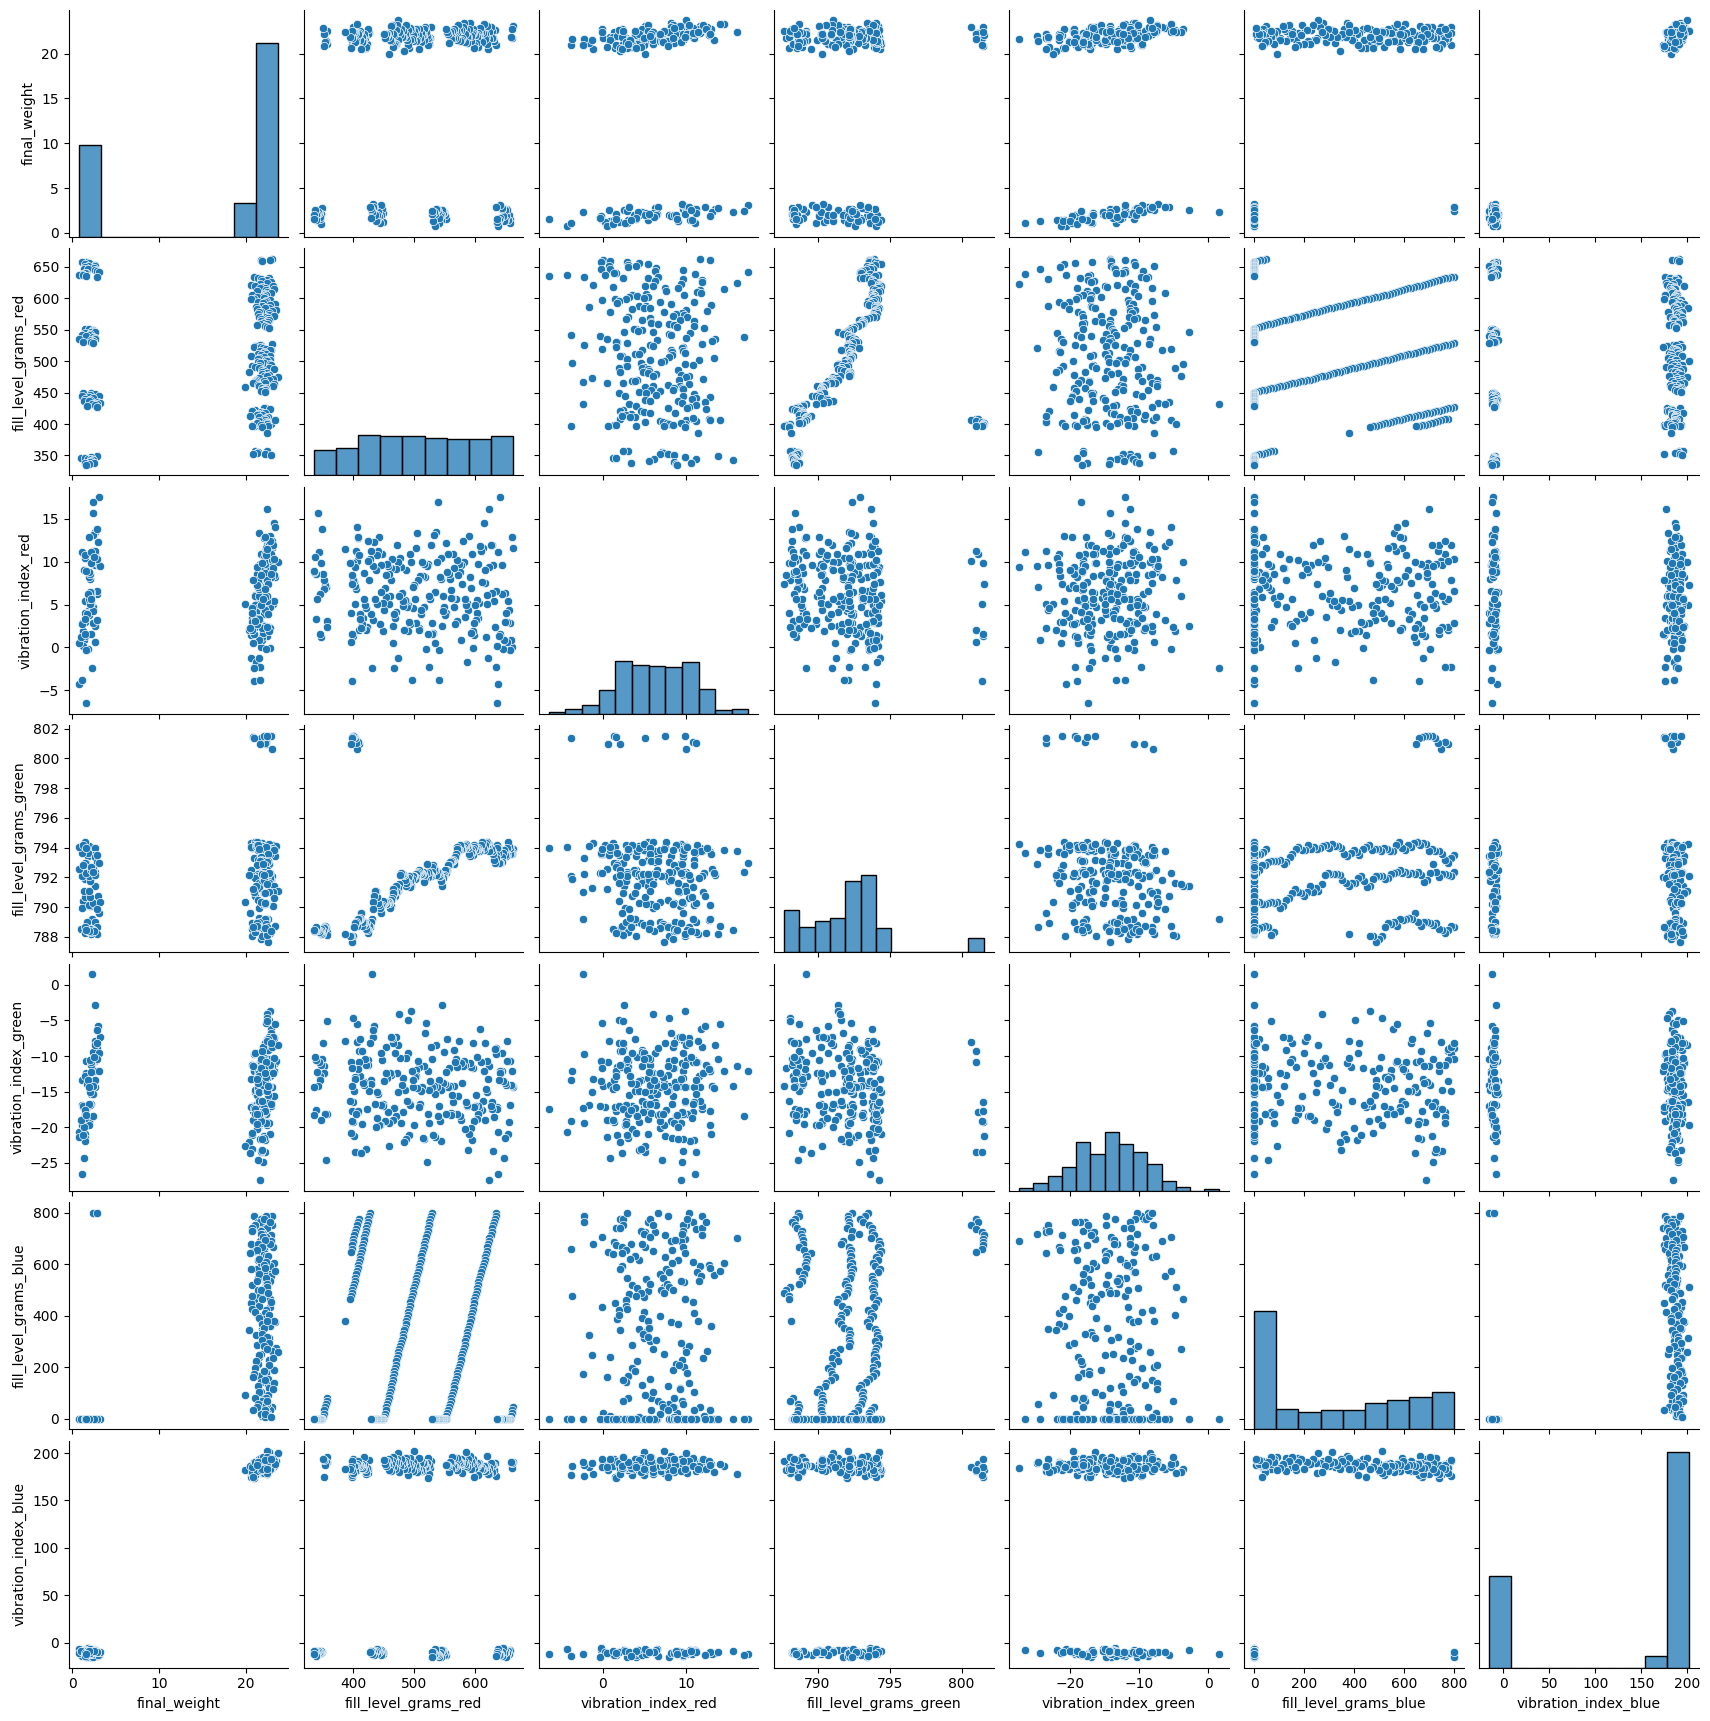

In [115]:
import json
import pandas as pd
import seaborn as sns

# Daten aus json auslesen
with open("../mqtt_data.json", "r") as f:
    data = json.load(f)

final_weight_entries = data.get("final_weight", {})
df_final_weight = pd.DataFrame([
    {
        "bottle": entry["bottle"],
        "time": pd.to_datetime(entry["time"], unit="s"),
        "final_weight": entry["final_weight"],
    }
    for entry in final_weight_entries.values()
])

dispenser_red_entries = data.get("dispenser_red", {})
df_dispenser_red = pd.DataFrame([
    {
        "bottle": entry["bottle"],
        "fill_level_grams_red": entry["fill_level_grams"],
        "vibration_index_red": entry["vibration-index"]
    }
    for entry in dispenser_red_entries.values()
])

dispenser_green_entries = data.get("dispenser_green", {})
df_dispenser_green = pd.DataFrame([
    {
        "bottle": entry["bottle"],
        "fill_level_grams_green": entry["fill_level_grams"],
        "vibration_index_green": entry["vibration-index"]
    }
    for entry in dispenser_green_entries.values()
])   

dispenser_blue_entries = data.get("dispenser_blue", {})
df_dispenser_blue = pd.DataFrame([
    {
        "bottle": entry["bottle"],
        "fill_level_grams_blue": entry["fill_level_grams"],
        "vibration_index_blue": entry["vibration-index"]
    }
    for entry in dispenser_blue_entries.values()
])

# Ausgelesene Daten in df zusammen mergen
df_regression = df_final_weight.copy()
df_regression = pd.merge(df_regression, df_dispenser_red, on='bottle', how='left')
df_regression = pd.merge(df_regression, df_dispenser_green, on='bottle', how='left')
df_regression = pd.merge(df_regression, df_dispenser_blue, on='bottle', how='left')
df_regression = df_regression.dropna()

print(df_regression)
sns.pairplot(df_regression)


## Trainings- und Testdaten

Nun da die Daten sich in sauber in einem Dataframe befinden, kann das Trainieren des Modells beginnen. Dazu werden die Daten in Trainings- und Testdaten unterteilt. Dies ist wichtig, um das Modell auf neuen, unbekannten Daten zu testen und zu validieren.
Die Unterteilung erfolgt mittels k-Fold Cross-Validation, `sk-learn` bietet dafür schon eine Funktion an.
Dies ermöglicht eine bessere Generalisierung des Modells.

Die vier Modelle die gewählt wurde sind `LinearRegression`, `SVR` (Support Vector Regression) und `RandomForestRegressor`. Diese Modelle sind gut geeignet, um die Beziehung zwischen den Eingangsvariablen und dem Endgewicht zu modellieren.

Zur einfachern Evaluierung wurde die `evaluate_model` Funktion geschrieben die mit das angegenen Modell trainiert und testet.

In [116]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_train, mse_test = [], []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))

    return np.mean(mse_train), np.mean(mse_test)

# Ergebnis-DataFrame vorbereiten
df_predictions = pd.DataFrame(columns=[
    "Genutzte Spalten",
    "Modell-Typ",
    "MSE-Wert (Training)",
    "MSE-Wert (Test)"
])

Nun wird einmal ein Modell mit den Füllleveln der einzelnen Dispensern trainiert.

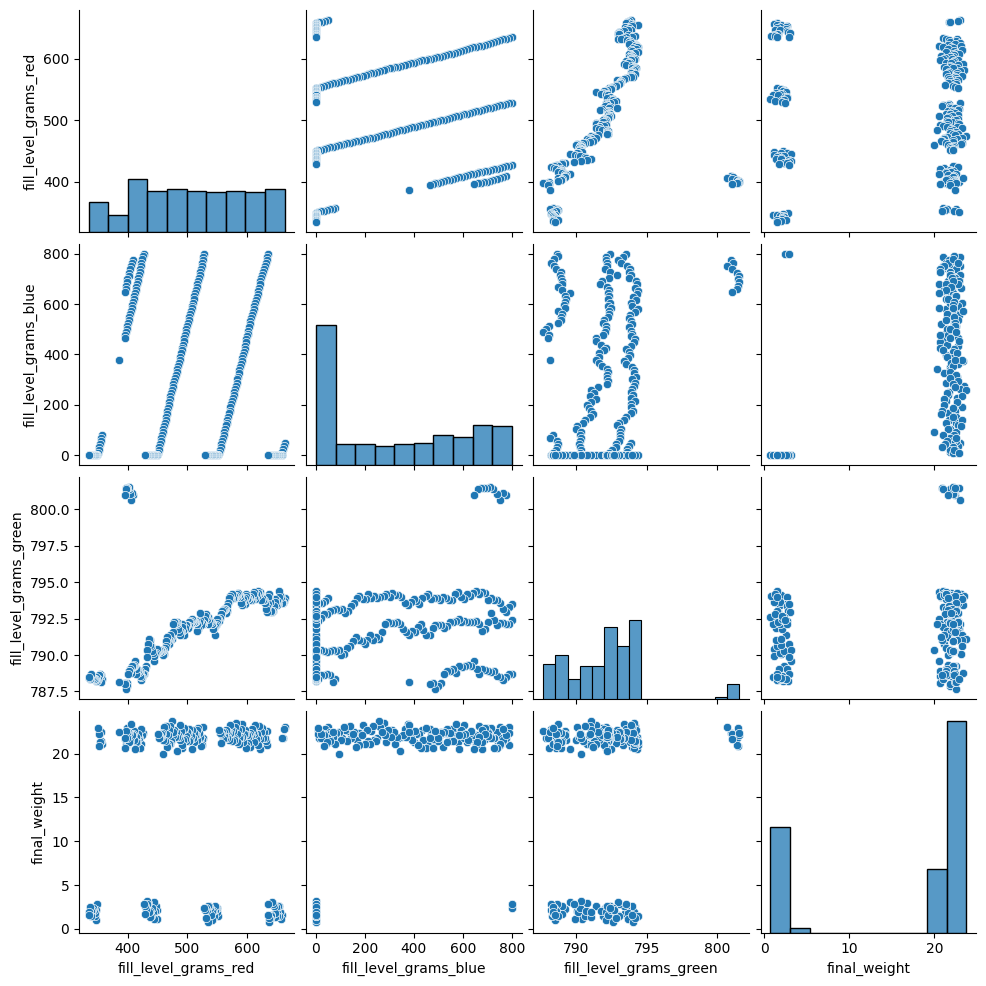

In [117]:
# Features & Ziel definieren
X = df_regression[['fill_level_grams_red',
                   'fill_level_grams_blue',
                   'fill_level_grams_green']]
y = df_regression['final_weight']

sns.pairplot(pd.concat([X, y]))

In [118]:
# Evaluation für jedes Modell durchführen und eintragen
linear_model = LinearRegression()
SVR_model = SVR(kernel="linear")
Forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

models = [
    ("Linear", linear_model),
    ("SVM", SVR_model),
    ("RandomForest", Forest_model)
]

for model_name, model in models:
    mse_train, mse_test = evaluate_model(model, X, y, k=9)

    df_predictions.loc[len(df_predictions)] = [
        list(X.columns),
        model_name,
        round(mse_train, 4),
        round(mse_test, 4)
    ]

print(df_predictions)

                                    Genutzte Spalten    Modell-Typ  \
0  [fill_level_grams_red, fill_level_grams_blue, ...        Linear   
1  [fill_level_grams_red, fill_level_grams_blue, ...           SVM   
2  [fill_level_grams_red, fill_level_grams_blue, ...  RandomForest   

   MSE-Wert (Training)  MSE-Wert (Test)  
0              50.2086          51.5616  
1              67.5608          81.0500  
2               0.1329           1.1385  


Nun wird das selber Training nochmals durchgeführt, jedoch dieses Mal werden die Vibrations Index Daten auch mit in das Training bezogen.

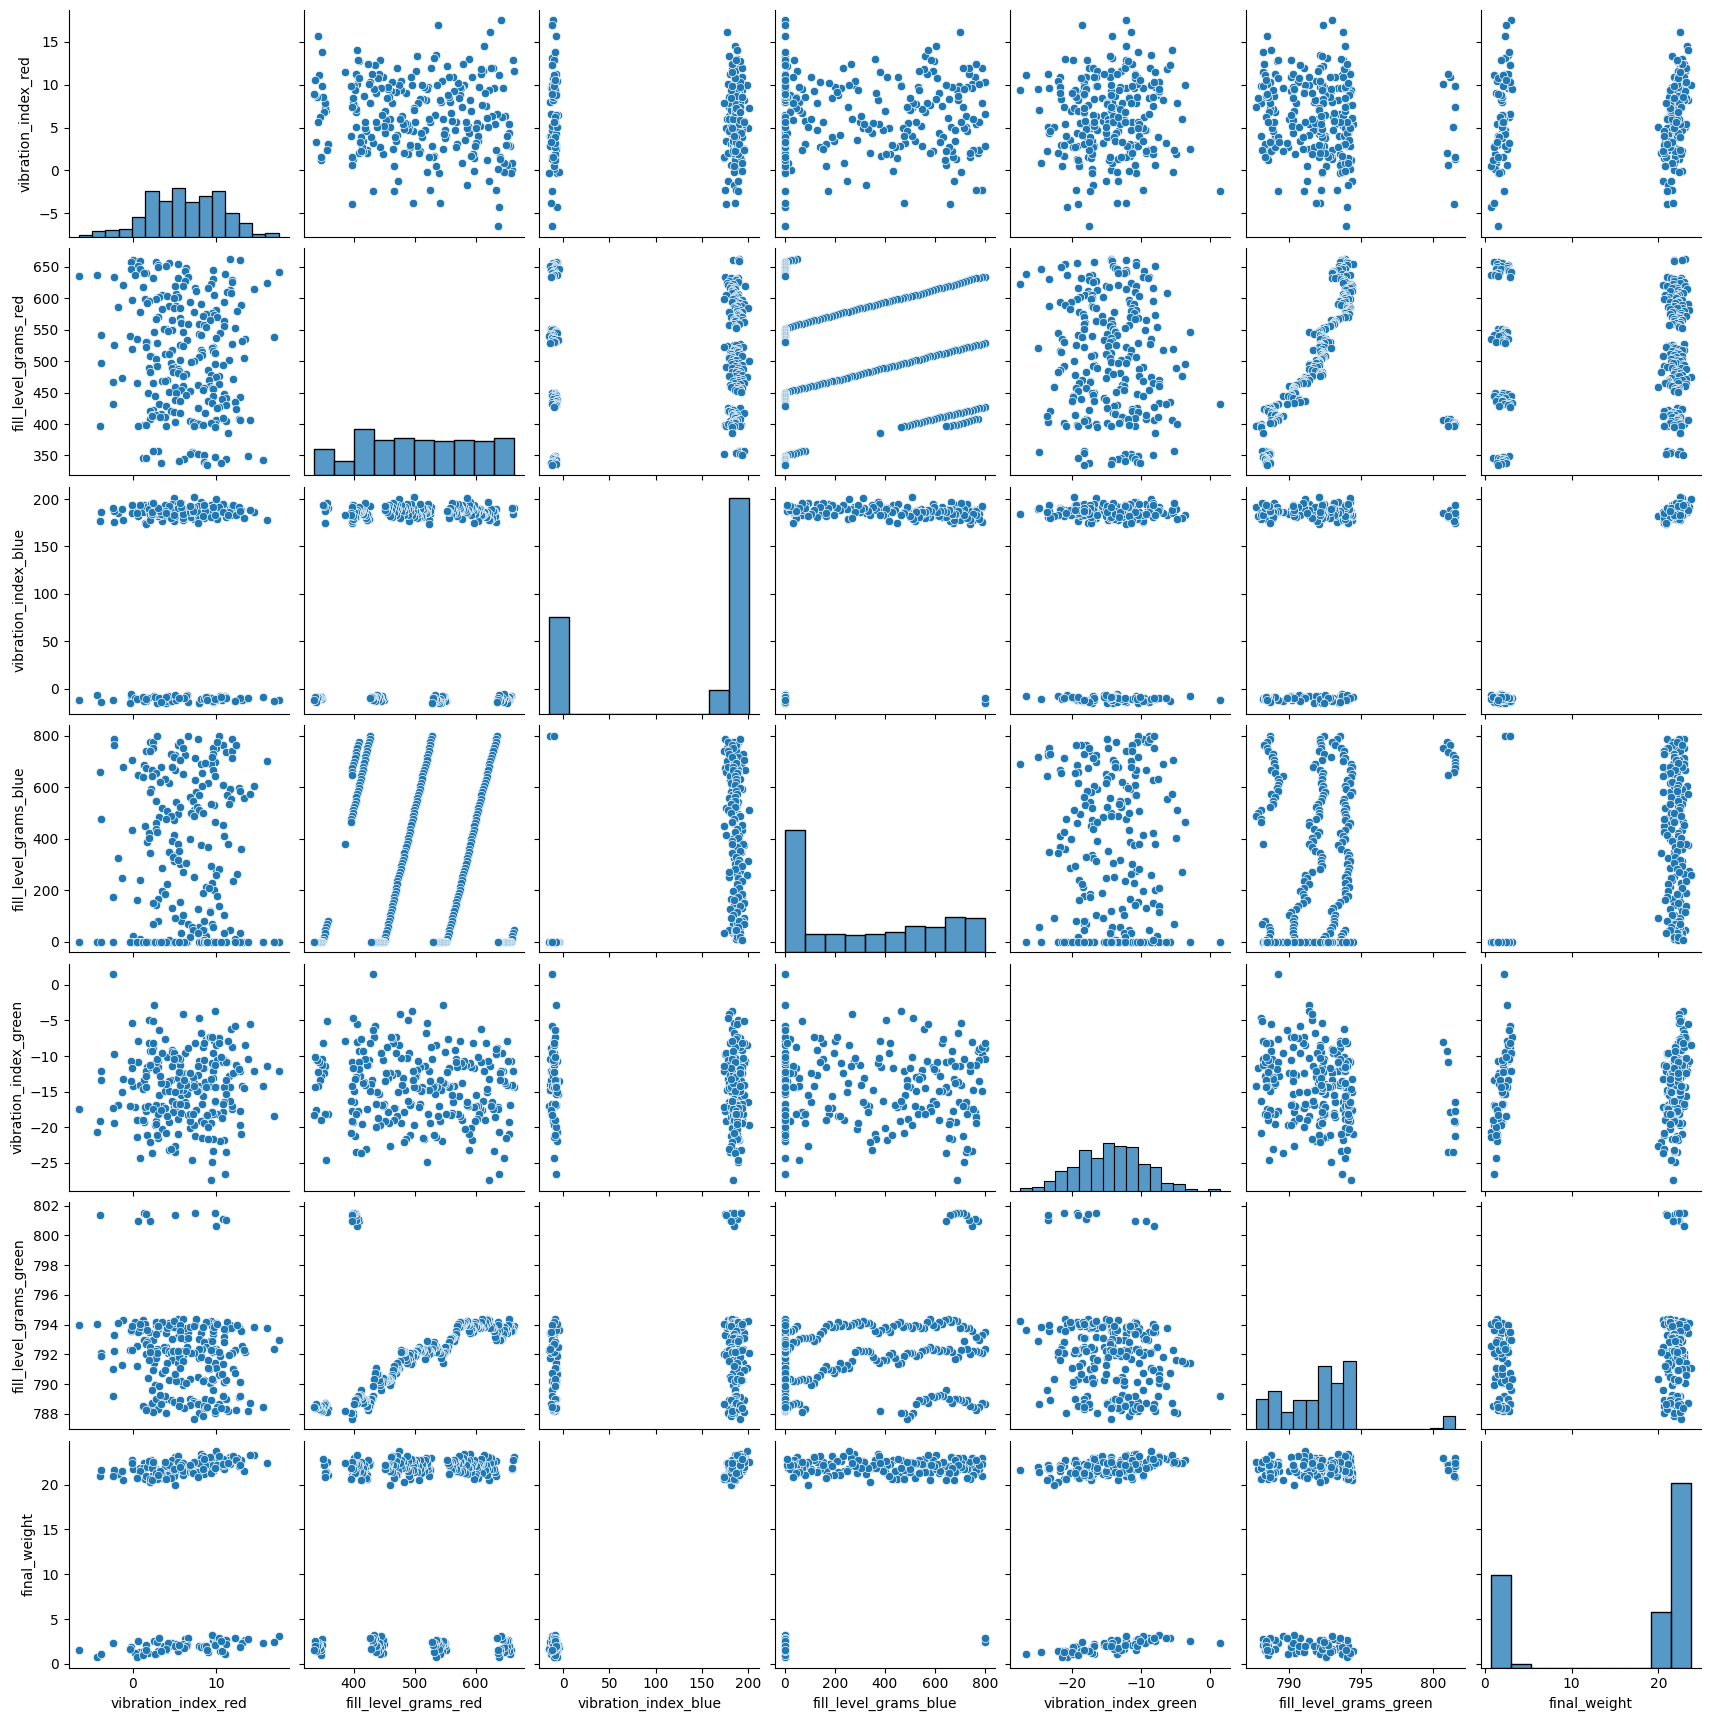

In [119]:
# Features & Ziel definieren
X = df_regression[['vibration_index_red','fill_level_grams_red',
                     'vibration_index_blue','fill_level_grams_blue',
                     'vibration_index_green','fill_level_grams_green']]
y = df_regression['final_weight']

sns.pairplot(pd.concat([X, y]))

In [120]:
# Evaluation für jedes Modell durchführen und eintragen
for model_name, model in models:
    mse_train, mse_test = evaluate_model(model, X, y, k=9)

    df_predictions.loc[len(df_predictions)] = [
        list(X.columns),
        model_name,
        round(mse_train, 4),
        round(mse_test, 4)
    ]

print(df_predictions)

                                    Genutzte Spalten    Modell-Typ  \
0  [fill_level_grams_red, fill_level_grams_blue, ...        Linear   
1  [fill_level_grams_red, fill_level_grams_blue, ...           SVM   
2  [fill_level_grams_red, fill_level_grams_blue, ...  RandomForest   
3  [vibration_index_red, fill_level_grams_red, vi...        Linear   
4  [vibration_index_red, fill_level_grams_red, vi...           SVM   
5  [vibration_index_red, fill_level_grams_red, vi...  RandomForest   

   MSE-Wert (Training)  MSE-Wert (Test)  
0              50.2086          51.5616  
1              67.5608          81.0500  
2               0.1329           1.1385  
3               0.1074           0.1132  
4               0.1177           0.1206  
5               0.0326           0.2912  


Von den **MSE-Werten** (Mean Squared Error) lässt sich ablesen, welches Modell sich am besten an die Daten annähert. Dabei gilt: **Je kleiner der MSE-Wert, desto besser** ist die Vorhersagegenauigkeit des Modells.

Zunächst ist ersichtlich, dass sich das Modell **deutlich verbessert**, sobald die **Vibrationsdaten** mit in die Regression aufgenommen werden.

Obwohl das `RandomForest`-Modell den **geringsten Fehler im Trainingsdatensatz** aufweist, ist es **nicht das beste Modell**, da der Fehler im **Testdatensatz deutlich höher** ist. Dies deutet auf **Overfitting** hin – das Modell hat sich zu stark an die Trainingsdaten angepasst und verallgemeinert schlecht.

Das **beste Modell** in diesem Fall ist daher die `Lineare Regression`, da der **MSE-Wert für Trainings- und Testdaten annähernd gleich und insgesamt niedrig** bleibt.

Da in dieser Linearen Regression **mehrere Merkmale (Features)** verwendet wurden, spricht man hier von einer **Multiplen Linearen Regression**. Entsprechend besitzt das Modell **mehrere Koeffizienten**, die jeweils die Stärke des Zusammenhangs zwischen den Features und dem Zielwert beschreiben. Diese Parameter werden hier nachfolgend angegeben.

In [121]:
coefficients = linear_model.coef_  # m
intercept = linear_model.intercept_  # b

for name, coef in zip(X.columns, coefficients):
    print(f"{name}: {coef:.4f}")
print(f"Intercept (b): {intercept:.4f}")

vibration_index_red: 0.0771
fill_level_grams_red: 0.0001
vibration_index_blue: 0.0999
fill_level_grams_blue: 0.0005
vibration_index_green: 0.0839
fill_level_grams_green: 0.0652
Intercept (b): -47.9233


Nun da ein gutes Modell trainiert wurde ist es Zeit dies an einem gegeben Datensatz `X.csv` anzuwenden.

Dafür muss zuerst wieder der Datensatz eingelesen werden un in einem `Dataframe` gespeichert werden.

In [122]:
df_X_csv = pd.read_csv("../X.csv")
print(df_X_csv)

     bottle  vibration_index_red  fill_level_grams_red  vibration_index_blue  \
0       368           222.532407             54.029687             31.623312   
1       369           213.845844             38.183543             23.665775   
2       370           215.491497             21.692003             24.171144   
3       371           -15.927028              0.000000             25.572354   
4       372           -20.639413              0.000000             26.986643   
..      ...                  ...                   ...                   ...   
242     637           221.166838            571.761046             32.371415   
243     638           216.972309            555.989551             29.762246   
244     639           221.201468            539.370235             31.921208   
245     640           217.534516            523.202020             30.224880   
246     641           208.434982            507.430440             29.530111   

     fill_level_grams_blue  vibration_i

Dann werden die richtigen Features aus dem `Dataframe` extrahiert und in einem neuen `Dataframe` gespeichert. Anschließend wird das trainierte Modell auf diesen Datensatz angewendet, um die Vorhersage zu erhalten.
Die Vorhersage wird dann in einer neuen CSV-Datei `prediction_output.csv` gespeichert.

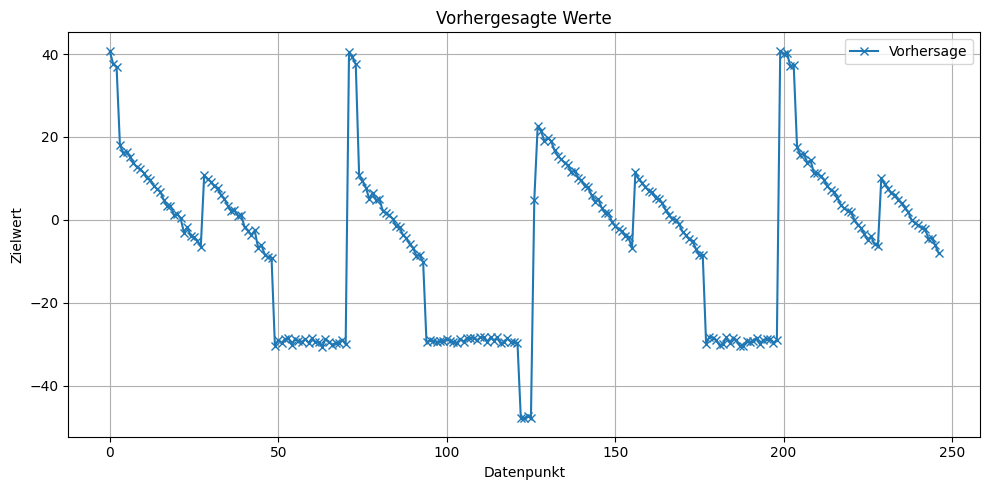

In [124]:
import matplotlib.pyplot as plt

X_csv = df_X_csv[['vibration_index_red','fill_level_grams_red',
              'vibration_index_blue','fill_level_grams_blue',
              'vibration_index_green','fill_level_grams_green']]

#model.fit(X_csv, y)
y_pred = linear_model.predict(X_csv)

# In CSV speichern
pd.DataFrame({"prediction": y_pred}).to_csv("../reg_<52315850-52315831-Matrikelnummer3>.csv.csv", index=False)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, label="Vorhersage", marker='x')
plt.title("Vorhergesagte Werte")
plt.xlabel("Datenpunkt")
plt.ylabel("Zielwert")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()